In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from utils import get_logicals
import stim
from scipy.sparse import lil_matrix
from tqdm import tqdm
from ldpc import bposd_decoder, bp_decoder
# %load_ext snakeviz

In [2]:
GF = galois.GF(2)
ccode = read_code("./codes/16_12_3_4.code")
H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1
dim0, dim1 = H.shape
print(H)
print(dim1 - np.linalg.matrix_rank(GF(H)))

[[0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1]
 [1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0]
 [0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0]
 [0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
4


(192, 400)


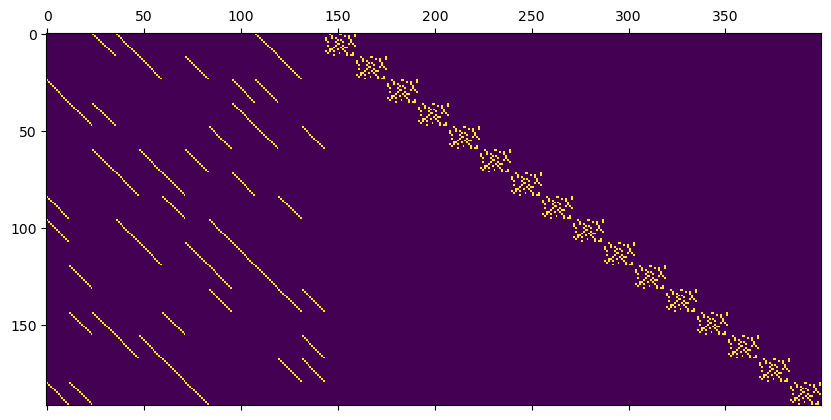

In [3]:
I1 = np.eye(dim1, dtype=int)
I0 = np.eye(dim0, dtype=int)

dE21 = np.kron(H, I0)
dE22 = np.kron(I1, H.T)
dE2 = np.vstack([dE21, dE22])
Hz = dE2.T

dE11 = np.kron(I0, H.T)
dE12 = np.kron(H, I1)
dE1 = np.hstack([dE11, dE12])
Hx = dE1

print(Hz.shape)
plt.matshow(Hz)

In [4]:
zL = get_logicals(Hx, Hz, False)
xL = get_logicals(Hx, Hz, True)
print(len(zL))

16


In [5]:
# iceberg642Xlogicals = np.array([
#     [0,1],
#     [0,2],
#     [0,3],
#     [0,4],
# ])

# iceberg642Zlogicals = np.array([
#     [1,5],
#     [2,5],
#     [3,5],
#     [4,5]
# ])

iceberg642Xlogicals = np.array([
    [1,2],
    [0,1],
    [4,5],
    [3,4],
])

iceberg642Zlogicals = np.array([
    [0,1],
    [1,2],
    [3,4],
    [4,5]
])


iceberg422Xlogicals = np.array([
    [0,1],
    [0,2]
])

iceberg422Zlogicals = np.array([
    [1,3],
    [2,3]
])

(100, 600)


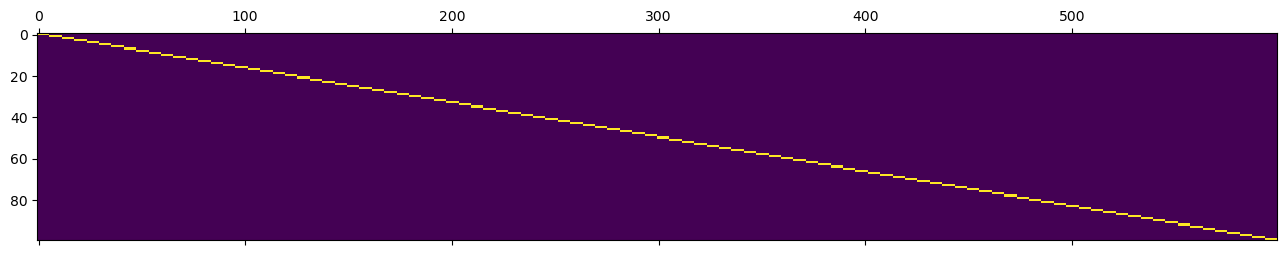

In [6]:
n = 6
k = n-2
icebergX = np.ones(n, dtype=int)
icebergZ = np.ones(n, dtype=int)
icebergXlogicals = iceberg422Xlogicals if n == 4 else iceberg642Xlogicals
icebergZlogicals = iceberg422Zlogicals if n == 4 else iceberg642Zlogicals

concatenatedStabilizersQED = np.kron(np.eye(int(np.ceil(Hx.shape[1]/(n-2))), dtype=int), icebergX)
print(concatenatedStabilizersQED.shape)
plt.matshow(concatenatedStabilizersQED)

In [7]:
concatenatedStabilizersXQEC = np.zeros(shape=(Hx.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedStabilizersZQEC = np.zeros(shape=(Hz.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(Hx):
    for x in np.where(r)[0]:
        concatenatedStabilizersXQEC[i][icebergXlogicals[x%k]+(n*(x//k))] ^= 1
        # print(x, x%4, x//4, "|", icebergXlogicals[x%k]+(n*(x//k))) # x%4 decides which logical, x//4 decides which block
    # print()

for i, r in enumerate(Hz):
    for z in np.where(r)[0]:
        concatenatedStabilizersZQEC[i][icebergZlogicals[z%k]+(n*(z//k))] ^= 1
    #     print(z, z%4, z//4, "|", icebergZlogicals[z%k]+(n*(z//k)))
    # print()

concatenatedHx = np.vstack([concatenatedStabilizersXQEC, concatenatedStabilizersQED][::-1])
concatenatedHz = np.vstack([concatenatedStabilizersZQEC, concatenatedStabilizersQED][::-1])

In [8]:
concatenatedxL = np.zeros(shape=(zL.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)
concatenatedzL = np.zeros(shape=(xL.shape[0], concatenatedStabilizersQED.shape[1]), dtype=int)

for i, r in enumerate(xL):
    for x in np.where(r)[0]:
        concatenatedxL[i][icebergXlogicals[x%k]+(n*(x//k))] ^= 1
        # print(x, x%4, x//4, "|", icebergXlogicals[x%k]+(n*(x//k))) # x%4 decides which logical, x//4 decides which block
    # print()

# for i, r in enumerate(Hz):
#     for z in np.where(r)[0]:
#         concatenatedStabilizersZQEC[i][icebergZlogicals[z%k]+(n*(z//k))] ^= 1
#     #     print(z, z%4, z//4, "|", icebergZlogicals[z%k]+(n*(z//k)))
#     # print()

In [9]:
concatenatedzL = get_logicals(concatenatedHx, concatenatedHz, False)
concatenatedxL = get_logicals(concatenatedHx, concatenatedHz, True)
print(len(concatenatedxL))

16


In [10]:
for l in concatenatedzL:
    print(np.where(l)[0])

[216 217 240 241 264 265 336 337 360 361 384 385]
[216 218 240 242 264 266 336 338 360 362 384 386]
[218 219 242 243 266 267 338 339 362 363 386 387]
[219 220 243 244 267 268 339 340 363 364 387 388]
[264 265 288 289 312 313 384 385 480 481 504 505]
[264 266 288 290 312 314 384 386 480 482 504 506]
[264 265 266 267 288 289 290 291 312 313 314 315 384 385 386 387 480 481
 482 483 504 505 506 507]
[266 268 290 292 314 316 386 388 482 484 506 508]
[219 220 240 241 243 244 267 268 312 313 336 337 339 340 363 364 387 388
 456 457 504 505 552 553]
[240 242 312 314 336 338 456 458 504 506 552 554]
[240 241 242 243 312 313 314 315 336 337 338 339 456 457 458 459 504 505
 506 507 552 553 554 555]
[242 244 314 316 338 340 458 460 506 508 554 556]
[264 265 384 385 408 409 432 433 456 457 528 529 552 553 576 577]
[264 266 384 386 408 410 432 434 456 458 528 530 552 554 576 578]
[264 265 266 267 384 385 386 387 408 409 410 411 432 433 434 435 456 457
 458 459 528 529 530 531 552 553 554 555 576 577

(292, 600)


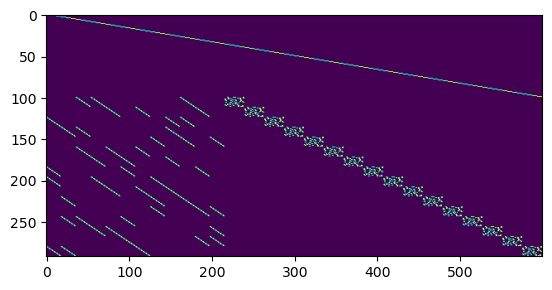

In [11]:
print(concatenatedHx.shape)
plt.imshow(concatenatedHz)

In [12]:
overlapping_x_generators = np.empty(concatenatedStabilizersQED.shape[0], dtype=object)
for i in range(concatenatedStabilizersQED.shape[0]):
    tmp = np.array([], dtype=int)
    for j in range(concatenatedStabilizersXQEC.shape[0]):
        if np.any(concatenatedStabilizersQED[i] & concatenatedStabilizersXQEC[j]): tmp = np.append(tmp, j+concatenatedStabilizersQED.shape[0])
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(concatenatedStabilizersQED.shape[0], dtype=object)
for i in range(concatenatedStabilizersQED.shape[0]):
    tmp = np.array([], dtype=int)
    for j in range(concatenatedStabilizersZQEC.shape[0]):
        if np.any(concatenatedStabilizersQED[i] & concatenatedStabilizersZQEC[j]): tmp = np.append(tmp, j+concatenatedStabilizersQED.shape[0])
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])
    return list(gens_to_measure)

In [13]:
def to_mtx(H):
    print("%%MatrixMarket matrix coordinate integer general\n")
    print(f"{H.shape[0]} {H.shape[1]} {np.count_nonzero(H)}")

    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if H[i][j]:
                print(f"{i+1} {j+1} 1")
# to_mtx(concatenatedHx)

In [332]:
cm, cn = concatenatedHx.shape
qedm, qedn = concatenatedStabilizersQED.shape
qecm, qecn = concatenatedStabilizersXQEC.shape
data_qbts = np.arange(cn)
x_checks = np.arange(cn,cn+cm)
z_checks = np.arange(cn+cm,cn+cm+cm)
all_qbts = np.arange(cn+cm+cm)

precomputed_x_checks_circuits = np.empty(cm, dtype=object)
for x in np.arange(cm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(concatenatedHx[x])[0]]
    for qbt in gen_qbts:
        path_qbts = [x_checks[x], qbt]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, 1.3e-3)
    precomputed_x_checks_circuits[x] = c

def prepare_x_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], 1e-5)
    for x in checks:
        c += precomputed_x_checks_circuits[x]
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], 1e-5)
    return c

precomputed_z_checks_circuits = np.empty(cm, dtype=object)
for z in np.arange(cm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(concatenatedHz[z])[0]]
    for qbt in gen_qbts:
        path_qbts = [qbt, z_checks[z]]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, 1.3e-3)
    precomputed_z_checks_circuits[z] = c

def prepare_z_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    for z in checks:
        c += precomputed_z_checks_circuits[z]
    return c

In [363]:
class Simulation:
    def __init__(self, num_rounds, stab_type):
        self.num_rounds = num_rounds
        self.stab_type = stab_type

        self.prev_meas_z = np.zeros(cm, dtype=int)
        self.prev_meas_x = np.zeros(cm, dtype=int)
        self.curr_meas_z = np.zeros(cm, dtype=int)
        self.curr_meas_x = np.zeros(cm, dtype=int)

        self.confirmation_z = np.ones(cm, dtype=int)
        self.confirmation_x = np.ones(cm, dtype=int)
        self.z_check_history = np.ones(cm, dtype=int)
        self.x_check_history = np.ones(cm, dtype=int)
        self.z_syndrome_history = np.zeros(shape=(num_rounds+1, cm), dtype=int)
        self.x_syndrome_history = np.zeros(shape=(num_rounds+1, cm), dtype=int)

        self.c = stim.Circuit()
        self.c.append("M", 0) # hacky way to make detectors that aren't affected by anything
        self.s = stim.TableauSimulator()

        if self.stab_type:
            self.c.append("H", [qbt for qbt in data_qbts])
            self.c += prepare_z_checks(np.arange(cm)).without_noise()
            # self.c.append("X_ERROR", z_checks, 2e-3)
            for i, z_check in enumerate(np.arange(cm)):
                self.c.append("MR", z_checks[z_check])
                self.prev_meas_z[z_check] = self.c.num_measurements
            # self.c.append("X_ERROR", z_checks, 1e-4)
        else:
            self.c += prepare_x_checks(np.arange(cm)).without_noise()
            # self.c.append("X_ERROR", x_checks, 2e-3)
            for i, x_check in enumerate(np.arange(cm)):
                self.c.append("MR", x_checks[x_check])
                self.prev_meas_x[x_check] = self.c.num_measurements
            # self.c.append("X_ERROR", x_checks, 1e-4)

        self.s.do_circuit(self.c)
        if self.stab_type:
            self.z_syndrome_history[0] = self.s.current_measurement_record()[1:]
        else:
            self.x_syndrome_history[0] = self.s.current_measurement_record()[1:]


    def detectors(self, stab_type):
        num_meas = self.c.num_measurements
        prev_meas = self.prev_meas_x if stab_type else self.prev_meas_z
        curr_meas = self.curr_meas_x if stab_type else self.curr_meas_z

        for i, check in enumerate(np.arange(cm)):
            if not prev_meas[i]:
                self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1) if curr_meas[i] else stim.target_rec(-num_meas)])
            # else:
            #     self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1), stim.target_rec(prev_meas[i]-num_meas-1)])
            prev_meas[i] = curr_meas[i]
            curr_meas[i] = 0

        # for i, check in enumerate(curr_meas):
        #     if check:
        #         if not prev_meas[i]:
        #             self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1)])
        #         else:
        #             self.c.append("DETECTOR", [stim.target_rec(curr_meas[i]-num_meas-1), stim.target_rec(prev_meas[i]-num_meas-1)])
        #         prev_meas[i] = curr_meas[i]
        #         curr_meas[i] = 0

        if stab_type:
            self.prev_meas_x = prev_meas
            self.curr_meas_x = curr_meas
        else:
            self.prev_meas_z = prev_meas
            self.curr_meas_z = curr_meas

    def final_detectors_and_observables(self, stab_type):
        c = stim.Circuit()

        if self.stab_type: self.c.append("H", [qbt for qbt in data_qbts])
        # self.c.append("X_ERROR", [qbt for qbt in data_qbts], 2e-3)
        c.append("M", data_qbts)

        num_meas = self.c.num_measurements + c.num_measurements
        H = concatenatedHx if stab_type else concatenatedHz
        prev_meas = self.prev_meas_x if stab_type else self.prev_meas_z
        for i in range(H.shape[0]):
            incl_qbts = np.where(H[i])[0]
            incl_qbts = [j-cn for j in incl_qbts]
            target_recs = [stim.target_rec(j) for j in incl_qbts]

            if prev_meas[i]:
                target_recs.append(stim.target_rec(prev_meas[i]-num_meas-1))
            c.append("DETECTOR", target_recs)


        for i, logical in enumerate(concatenatedxL if stab_type else concatenatedzL):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [j-cn for j in incl_qbts]
            c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)
        return c

    def QED(self):
        def measure_z_qed_checks(c):
            c += prepare_z_checks(np.arange(qedm))
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qedm)], 2e-3)
            for i, z_check in enumerate(np.arange(qedm)):
                c.append("MR", z_checks[z_check])
                self.curr_meas_z[z_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qedm)], 1e-4)
            return c

        def measure_x_qed_checks(c):
            c += prepare_x_checks(np.arange(qedm))
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qedm)], 2e-3)
            for i, x_check in enumerate(np.arange(qedm)):
                c.append("MR", x_checks[x_check])
                self.curr_meas_x[x_check] = self.c.num_measurements + c.num_measurements
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qedm)], 1e-4)
            return c

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qed_checks(c)
            c = measure_z_qed_checks(c)
        else:
            c = measure_z_qed_checks(c)
            c = measure_x_qed_checks(c)
        return c

    def QEC(self):
        def measure_z_qec_checks(c, curr_z_checks):
            c += prepare_z_checks(curr_z_checks)
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], 2e-3)
            for i, z_check in enumerate(curr_z_checks):
                c.append("MR", z_checks[z_check])
                self.curr_meas_z[z_check] = self.c.num_measurements + c.num_measurements
            # # for i, z_check in enumerate(np.arange(qedm, cm)):  # no idea why this causes errors to appear
            # #     c.append("R", z_check)
            c.append("X_ERROR", z_checks, 1e-4)
            return c

        def measure_x_qec_checks(c, curr_x_checks):
            c += prepare_x_checks(curr_x_checks)
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], 2e-3)
            for i, x_check in enumerate(curr_x_checks):
                c.append("MR", x_checks[x_check])
                self.curr_meas_x[x_check] = self.c.num_measurements + c.num_measurements
            # # for i, x_check in enumerate(np.arange(qedm, cm)):
            # #     c.append("R", x_check)
            c.append("X_ERROR", x_checks, 1e-4)
            return c

        curr_z_checks = np.arange(qedm, cm)[self.confirmation_z[qedm:]==1]
        curr_x_checks = np.arange(qedm, cm)[self.confirmation_x[qedm:]==1]

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qec_checks(c, curr_x_checks)
            c = measure_z_qec_checks(c, curr_z_checks)
        else:
            c = measure_z_qec_checks(c, curr_z_checks)
            c = measure_x_qec_checks(c, curr_x_checks)
        return c

    def simulate(self):
        self.s.x(265)
        for i in range(1, self.num_rounds+1):
            self.c.append("X_ERROR", data_qbts, 0.000001)  # idle errors
            # self.s.x_error(*data_qbts, p=0.01)

            self.z_syndrome_history[i] = self.z_syndrome_history[i-1]
            self.x_syndrome_history[i] = self.x_syndrome_history[i-1]

            QED_circuit = self.QED()
            self.s.do_circuit(QED_circuit)
            self.c += QED_circuit

            # determining which of the QEC stabilizers to measure
            meas = self.s.current_measurement_record()
            self.z_syndrome_history[i][:qedm] = meas[-(2*qedm):-qedm]
            self.x_syndrome_history[i][:qedm] = meas[-qedm:]

            z_qed_synd_diff = self.z_syndrome_history[i-1][:qedm] ^ self.z_syndrome_history[i][:qedm]
            x_qed_synd_diff = self.x_syndrome_history[i-1][:qedm] ^ self.x_syndrome_history[i][:qedm]

            curr_z_checks = get_overlapping(z_qed_synd_diff, False)
            curr_x_checks = get_overlapping(x_qed_synd_diff, True)
            print(i, np.where(z_qed_synd_diff)[0], curr_z_checks)
            # print(curr_x_checks)

            self.confirmation_z = np.array([1 if ((z < qedm) or (z in curr_z_checks)) else 0 for z in np.arange(cm)])
            self.confirmation_x = np.array([1 if ((x < qedm) or (z in curr_x_checks)) else 0 for x in np.arange(cm)])
            self.z_check_history = np.vstack([self.z_check_history, self.confirmation_z])
            self.x_check_history = np.vstack([self.x_check_history, self.confirmation_x])

            QEC_circuit = self.QEC()
            self.s.do_circuit(QEC_circuit)
            self.c += QEC_circuit

            meas = self.s.current_measurement_record()
            lookback = lambda x: -len(x) if len(x) else None

            if len(curr_z_checks): self.z_syndrome_history[i][sorted(curr_z_checks)] = meas[lookback(curr_z_checks+curr_x_checks):lookback(curr_x_checks)]
            if len(curr_x_checks): self.x_syndrome_history[i][sorted(curr_x_checks)] = meas[lookback(curr_x_checks):]

            self.detectors(self.stab_type)

        obs_circuit = self.final_detectors_and_observables(self.stab_type)
        self.s.do_circuit(obs_circuit)
        self.c += obs_circuit

In [364]:
s = Simulation(1, False)
s.simulate()
c = s.c

1 [27 44] [128, 130, 132, 133, 134, 148, 149, 150, 151, 220, 221, 222, 223, 100, 101, 102, 103, 124, 125, 126, 127]


In [365]:
xL_inds = [np.where(x)[0] for x in concatenatedxL]
zL_inds = [np.where(z)[0] for z in concatenatedzL]

data_qbts_meas = np.array(s.s.current_measurement_record()[-cn:])
observable = []
for l in zL_inds:
    qbts = data_qbts_meas[l]
    observable.append(np.count_nonzero(qbts) % 2)
observable

[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]

In [366]:
final_synd = []
for j in range(concatenatedHz.shape[0]):
    qbts = data_qbts_meas[np.where(concatenatedHz[j])[0]]
    final_synd.append(np.count_nonzero(qbts) % 2)
s.z_syndrome_history = np.vstack([s.z_syndrome_history, final_synd])
final_synd = []
for j in range(concatenatedHx.shape[0]):
    qbts = data_qbts_meas[np.where(concatenatedHx[j])[0]]
    final_synd.append(np.count_nonzero(qbts) % 2)
s.x_syndrome_history = np.vstack([s.x_syndrome_history, final_synd])

In [367]:
s.z_syndrome_history

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 

In [368]:
len(s.s.current_measurement_record())

1114

In [369]:
 # building and decoding circuit-level Tanner graph
dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=int)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=int)

channel_probs = [e.args_copy()[0] for e in dem if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    _dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    _obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[_dets],i] = 1
    lcm[[_obs],i] = 1

In [370]:
dets = np.zeros((len(s.z_syndrome_history)-1, cm), dtype=int)
for i in range(dets.shape[0]):
    dets[i] = s.z_syndrome_history[i] ^ s.z_syndrome_history[i+1]
dets = dets.flatten()

In [371]:
bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=100, #concatenatedHz.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=min(Hz.shape[0],10) #the osd search depth
)

In [372]:
guess = bposd_dec.decode(dets)
print(guess)

[0 0 0 ... 0 0 0]


In [373]:
(lcm @ guess) % 2

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int32)

In [374]:
observable

[1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]

In [387]:
# %%snakeviz
# not circuit-level decoding, but still circuit-level simulation
def QED():
    c = stim.Circuit()
    c += prepare_z_checks(np.arange(qedm))
    c += prepare_x_checks(np.arange(qedm))

    c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qedm)], 2e-3)
    c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qedm)], 2e-3)

    c.append("MR", [z_checks[z_check] for z_check in np.arange(qedm)])
    c.append("MR", [x_checks[x_check] for x_check in np.arange(qedm)])

    c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qedm)], 1e-4)
    c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qedm)], 1e-4)

    return c

def QEC(curr_z_gens, curr_x_gens):
    c = stim.Circuit()
    c += prepare_z_checks(curr_z_gens)
    c += prepare_x_checks(curr_x_gens)

    c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_gens], 2e-3)
    c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_gens], 2e-3)

    c.append("MR", [z_checks[z_check] for z_check in curr_z_gens])
    c.append("MR", [x_checks[x_check] for x_check in curr_x_gens])

    c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_gens], 1e-4)
    c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_gens], 1e-4)

    return c

def observables(stab_type):
    c = stim.Circuit()
    if stab_type: c.append("MX", data_qbts)
    else: c.append("M", data_qbts)
    return c


def get_overlapping(measurements, gen_type=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])
    return list(gens_to_measure)



bposd_dec = bposd_decoder(
    concatenatedHz, # the parity check matrix
    error_rate=1e-3,
    # channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=1000, #concatenatedHz.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
#     osd_order=min(concatenatedHz.shape[0],10) #the osd search depth
)

###########################

num_rounds = 1

x_corrections = np.zeros(cn, dtype=int)
z_corrections = np.zeros(cn, dtype=int)

all_x_synds = np.zeros(shape=(num_rounds+1, cm), dtype=int)
all_z_synds = np.zeros(shape=(num_rounds+1, cm), dtype=int)

QED_circuit = QED()

# initialization in the Z basis
c = stim.Circuit()
s = stim.TableauSimulator()

c += prepare_x_checks(np.arange(cm))
# c.append("X_ERROR", x_checks, 2e-3)
for i, x_check in enumerate(np.arange(cm)):
    c.append("MR", x_checks[x_check])
# c.append("X_ERROR", x_checks, 1e-4)

s.do_circuit(c)
all_x_synds[0] = s.current_measurement_record()

error_c = stim.Circuit()
error_c.append("X_ERROR", data_qbts, 0.001)

for i in range(1,num_rounds+1):

    all_z_synds[i] = all_z_synds[i-1]
    all_x_synds[i] = all_x_synds[i-1]

    s.do_circuit(QED_circuit)
    c += QED_circuit
    meas = s.current_measurement_record()

    all_z_synds[i][:qedm] = meas[-(2*qedm):-qedm]
    all_x_synds[i][:qedm] = meas[-qedm:]
    z_qed_synd_diff = all_z_synds[i-1][:qedm] ^ meas[-(2*qedm):-qedm]
    x_qed_synd_diff = all_x_synds[i-1][:qedm] ^ meas[-qedm:]

    curr_z_gens = get_overlapping(z_qed_synd_diff, False)
    curr_x_gens = get_overlapping(x_qed_synd_diff, True)

    print(np.where(z_qed_synd_diff)[0], curr_z_gens)
    s.do_circuit(QEC(curr_z_gens, curr_x_gens))
    c += QEC(curr_z_gens, curr_x_gens)

    meas = s.current_measurement_record()
    lookback = lambda x: -len(x) if len(x) else None

    if len(curr_z_gens): all_z_synds[i][curr_z_gens] = meas[lookback(curr_z_gens+curr_x_gens):lookback(curr_x_gens)]
    if len(curr_x_gens): all_x_synds[i][curr_x_gens] = meas[lookback(curr_x_gens):]


    # bposd_dec.update
    x_corrections ^= bposd_dec.decode(all_z_synds[i] ^ all_z_synds[i-1])
    # z_corrections ^= bposd_dec.decode(all_x_synds[i] ^ all_x_synds[i-1])


s.do_circuit(observables(False))
# c += observables(False)
# destructive measurement, construct stabilizers manually

(array([ 44, 126, 127, 128, 130, 133, 134], dtype=int64),)


In [ ]:
tmp = np.vstack([concatenatedHx, x_corrections])
np.linalg.matrix_rank(GF(tmp))